In [0]:
Домашнее задание по лекции "Современные сверточные архитектуры" DLL-2

Основное задание
Возьмите датасет https://www.kaggle.com/ajayrana/hymenoptera-data/kernels
1.Обучите на нем модели ResNet 18 и VGG 16 с нуля (5-10 эпох)
2.Обучите на нем модели ResNet 18 и VGG 16 с использованием FineTuning (5-10 эпох)
3.Добавьте аугментацию данных к пункту 2

Сравните качество всех 3 полученных подходов

Задание со звездочкой
Примените FineTuning ResNet 18 к FashionMnist. Удалось ли увидеть резкое увеличение качества?

In [0]:
https://www.kaggle.com/mnagao/pytorch-hymenoptera

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [0]:
import albumentations as A
import cv2
import pandas as pd

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [81]:
#root_path = 'gdrive/My Drive/data_science/hymenoptera-data/'
root_path = '/content/gdrive/My Drive/data_science/hymenoptera_data'
for i in os.listdir(root_path):
  print(i)

train
hymenoptera_data
val


In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"zamarseny","key":"e3f17ee98642f76422b3e51ec459454c"}'}

In [8]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [0]:
#pic=cv2.imread('drive/My Drive/triangulated-image.png')


In [77]:
#!cd drive/
#!cd 'drive/My Drive'
#cd data_science/
#cd hymenoptera_data/
cd /content/gdrive/My Drive/data_science/hymenoptera_data

/content/gdrive/My Drive/data_science/hymenoptera_data


In [78]:
!ls

hymenoptera_data  train  val


In [54]:
#!kaggle competitions list
!kaggle datasets list -s hym

ref                          title             size  lastUpdated          downloadCount  
---------------------------  ----------------  ----  -------------------  -------------  
ajayrana/hymenoptera-data    hymenoptera_data  90MB  2017-12-14 13:01:49            541  
jiweiliu/hymenoptera-data    hymenoptera_data  45MB  2019-09-07 00:09:39             28  
zuozhaorui/hymenoptera-data  hymenoptera_data  90MB  2018-10-25 05:57:04              9  


In [0]:
#!kaggle competitions download -c https://www.kaggle.com/ajayrana/hymenoptera-data -p drive/My Drive/kaggle/hymenoptera_data/
#!kaggle competitions download -c hymenoptera-data -p drive/My Drive/kaggle/hymenoptera_data/

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '../input/hymenoptera-data/hymenoptera_data/hymenoptera_data'
data_dir='/content/gdrive/My Drive/data_science/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes



In [159]:
class_names

['ants', 'bees']

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/util.py", line 262, in _run_finalizers
    finalizer()
  File "/usr/lib/python3.6/multiprocessing/util.py", line 186, in __call__
    res = self._callback(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/shutil.py", line 490, in rmtree
    onerror(os.rmdir, path, sys.exc_info())
  File "/usr/lib/python3.6/shutil.py", line 488, in rmtree
    os.rmdir(path)
OSError: [Errno 39] Directory not empty: '/tmp/pymp-2hn9jlrj'


torch.Size([4, 3, 224, 224])


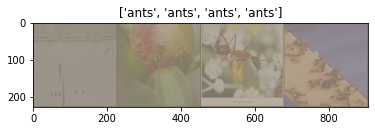

In [171]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))
print(inputs.shape)

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [0]:
#Training the model

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [0]:
#model_ft = models.resnet18(pretrained=True)
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [188]:
model_ft

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [175]:
model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.9314 Acc: 0.4713
val Loss: 0.7873 Acc: 0.6078

Epoch 1/9
----------
train Loss: 0.7495 Acc: 0.5574
val Loss: 0.8026 Acc: 0.5425

Epoch 2/9
----------
train Loss: 0.7190 Acc: 0.5984
val Loss: 0.9082 Acc: 0.5163

Epoch 3/9
----------
train Loss: 0.6805 Acc: 0.5984
val Loss: 0.9364 Acc: 0.5556

Epoch 4/9
----------
train Loss: 0.6889 Acc: 0.6148
val Loss: 0.9079 Acc: 0.5882

Epoch 5/9
----------
train Loss: 0.6664 Acc: 0.5738
val Loss: 0.6826 Acc: 0.6863

Epoch 6/9
----------
train Loss: 0.6469 Acc: 0.6557
val Loss: 0.7367 Acc: 0.5752

Epoch 7/9
----------
train Loss: 0.6137 Acc: 0.6393
val Loss: 0.8018 Acc: 0.5752

Epoch 8/9
----------
train Loss: 0.6067 Acc: 0.7090
val Loss: 0.6823 Acc: 0.6013

Epoch 9/9
----------
train Loss: 0.6117 Acc: 0.6844
val Loss: 0.6401 Acc: 0.6928

Training complete in 0m 41s
Best val Acc: 0.692810


In [176]:
best_acc.item()

0.6928104575163399

In [177]:
st=str(model_ft)
st=st.split('(')[0]
st

'ResNet'

In [0]:
df=pd.DataFrame(data=None, columns=['dataset','model', 'pretrained', 'augumentations', 'num_epochs','best_val_acc'])

In [0]:
df.loc[0]=['hymenoptera_data', str(model_ft).split('(')[0], False, 'no_augs', 10, best_acc.item()]

In [183]:
df

,dataset,model,pretrained,augumentations,num_epochs,best_val_acc
0,hymenoptera_data,ResNet,False,no_augs,10,0.69281


In [0]:
model_ft = models.vgg16(pretrained=False)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_ft.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [200]:
model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.4709 Acc: 0.4385
val Loss: 0.6999 Acc: 0.5425

Epoch 1/9
----------
train Loss: 0.7643 Acc: 0.5082
val Loss: 0.6977 Acc: 0.5425

Epoch 2/9
----------
train Loss: 0.7120 Acc: 0.5205
val Loss: 0.7143 Acc: 0.5425

Epoch 3/9
----------
train Loss: 0.7353 Acc: 0.4795
val Loss: 0.7069 Acc: 0.4575

Epoch 4/9
----------
train Loss: 0.7162 Acc: 0.4836
val Loss: 0.6903 Acc: 0.5425

Epoch 5/9
----------
train Loss: 0.7013 Acc: 0.5492
val Loss: 0.7338 Acc: 0.5425

Epoch 6/9
----------
train Loss: 0.7130 Acc: 0.5000
val Loss: 0.6949 Acc: 0.4575

Epoch 7/9
----------
train Loss: 0.7030 Acc: 0.5000
val Loss: 0.6980 Acc: 0.4575

Epoch 8/9
----------
train Loss: 0.6935 Acc: 0.5328
val Loss: 0.6943 Acc: 0.4575

Epoch 9/9
----------
train Loss: 0.6956 Acc: 0.5164
val Loss: 0.6939 Acc: 0.4575

Training complete in 1m 3s
Best val Acc: 0.542484


In [201]:
str(model_ft).split('(')[0]

'VGG'

In [0]:
df.loc[1]=['hymenoptera_data', str(model_ft).split('(')[0], False, 'no_augs', 10, best_acc.item()]

In [203]:
df

,dataset,model,pretrained,augumentations,num_epochs,best_val_acc
0,hymenoptera_data,ResNet,False,no_augs,10,0.692810
1,hymenoptera_data,VGG,False,no_augs,10,0.542484


Augumentations


In [0]:
data_transforms = {
    'train': transforms.Compose([
        #transforms.Resize((224,224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((256,256)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '../input/hymenoptera-data/hymenoptera_data/hymenoptera_data'
data_dir='/content/gdrive/My Drive/data_science/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [212]:
'''
data_transforms = {
    'train': A.Compose([
        A.HueSaturationValue(\
                         hue_shift_limit=0.2, \
                         sat_shift_limit=0.2, \
                         val_shift_limit=0.3, \
                         p=0.1),
        A.OneOf([
            #MotionBlur(p=0.8),
            A.MedianBlur(blur_limit=5, p=0.1),
            A.Blur(blur_limit=8, p=0.1),
        ], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=25, p=0.3),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.2),
        A.OpticalDistortion(p=0.3),
        A.RandomBrightnessContrast(p=0.3),
        A.RandomCrop(height=200, width=200, p=0.25),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
      'val': A.Compose([
        A.Resize(224,224),
        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        A.ToTensor(num_classes=1, sigmoid=True, normalize=None)
        #A.pytorch.transforms.ToTensorV2()
    ]),
}
'''

"\ndata_transforms = {\n    'train': A.Compose([\n        A.HueSaturationValue(                         hue_shift_limit=0.2,                          sat_shift_limit=0.2,                          val_shift_limit=0.3,                          p=0.1),\n        A.OneOf([\n            #MotionBlur(p=0.8),\n            A.MedianBlur(blur_limit=5, p=0.1),\n            A.Blur(blur_limit=8, p=0.1),\n        ], p=0.2),\n        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=25, p=0.3),\n        A.HorizontalFlip(p=0.5),\n        A.VerticalFlip(p=0.2),\n        A.OpticalDistortion(p=0.3),\n        A.RandomBrightnessContrast(p=0.3),\n        A.RandomCrop(height=200, width=200, p=0.25),\n        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])\n        ]),\n      'val': A.Compose([\n        A.Resize(224,224),\n        A.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),\n        A.ToTensor(num_classes=1, sigmoid=True, normalize=None)\n        #A.pytorch.transforms

In [236]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
#for L in model_ft:
#  L.requires_grad = False
model_ft.requires_grad=False

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.9472 Acc: 0.5902
val Loss: 2.7165 Acc: 0.5163

Epoch 1/9
----------
train Loss: 0.7175 Acc: 0.6107
val Loss: 0.6654 Acc: 0.5621

Epoch 2/9
----------
train Loss: 0.7459 Acc: 0.5246
val Loss: 1.6736 Acc: 0.6144

Epoch 3/9
----------
train Loss: 0.6743 Acc: 0.6434
val Loss: 1.4228 Acc: 0.5163

Epoch 4/9
----------
train Loss: 0.7153 Acc: 0.5779
val Loss: 0.8361 Acc: 0.6797

Epoch 5/9
----------
train Loss: 0.7665 Acc: 0.5615
val Loss: 0.6764 Acc: 0.6732

Epoch 6/9
----------
train Loss: 0.6622 Acc: 0.6270
val Loss: 0.6231 Acc: 0.6601

Epoch 7/9
----------
train Loss: 0.5897 Acc: 0.7090
val Loss: 0.6281 Acc: 0.6928

Epoch 8/9
----------
train Loss: 0.6486 Acc: 0.6270
val Loss: 0.6016 Acc: 0.7124

Epoch 9/9
----------
train Loss: 0.6127 Acc: 0.6844
val Loss: 0.7354 Acc: 0.7255

Training complete in 0m 43s
Best val Acc: 0.725490


In [0]:
df.loc[2]=['hymenoptera_data', str(model_ft).split('(')[0], True, 'simple_augs', 10, best_acc.item()]

In [238]:
df

,dataset,model,pretrained,augumentations,num_epochs,best_val_acc
0,hymenoptera_data,ResNet,False,no_augs,10,0.692810
1,hymenoptera_data,VGG,False,no_augs,10,0.542484
2,hymenoptera_data,ResNet,True,simple_augs,10,0.725490
3,hymenoptera_data,VGG,True,simple_augs,30,0.620915
4,hymenoptera_data,ResNet,True,no_augs,10,0.797386
5,hymenoptera_data,VGG,True,no_augs,10,0.666667


In [0]:
#ПОКА НЕ НАШЕЛ КАК у VGG16 ЗАМОРОЗИТЬ слои извлекающие фичи и заменить классификационную голову
model_ft = models.vgg16(pretrained=True)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_ft.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [243]:
#ЗАПУСТИЛ 15 ЭПОХ, чтобы увидеть точность больше 0.5. Обучение не идет в этой конфигурации
model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=15)

Epoch 0/14
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.4676 Acc: 0.5205
val Loss: 0.6997 Acc: 0.4575

Epoch 1/14
----------
train Loss: 0.7754 Acc: 0.4508
val Loss: 0.7099 Acc: 0.4575

Epoch 2/14
----------
train Loss: 0.7388 Acc: 0.5000
val Loss: 0.7104 Acc: 0.4575

Epoch 3/14
----------
train Loss: 0.7266 Acc: 0.4918
val Loss: 0.6905 Acc: 0.5425

Epoch 4/14
----------
train Loss: 0.7507 Acc: 0.4754
val Loss: 0.6934 Acc: 0.5425

Epoch 5/14
----------
train Loss: 0.7147 Acc: 0.5000
val Loss: 0.6912 Acc: 0.5425

Epoch 6/14
----------
train Loss: 0.7060 Acc: 0.5000
val Loss: 0.6931 Acc: 0.5425

Epoch 7/14
----------
train Loss: 0.7201 Acc: 0.4426
val Loss: 0.6922 Acc: 0.5425

Epoch 8/14
----------
train Loss: 0.7145 Acc: 0.5164
val Loss: 0.6948 Acc: 0.4575

Epoch 9/14
----------
train Loss: 0.7096 Acc: 0.4631
val Loss: 0.6944 Acc: 0.4575

Epoch 10/14
----------
train Loss: 0.6981 Acc: 0.5287
val Loss: 0.6937 Acc: 0.4575

Epoch 11/14
----------
train Loss: 0.7092 Acc: 0.5205
val Loss: 0.6916 Acc: 0.5425

Epoch 12/14
----------
t

In [0]:
df.loc[3]=['hymenoptera_data', str(model_ft).split('(')[0], True, 'simple_augs', 15, best_acc.item()]

In [245]:
df

,dataset,model,pretrained,augumentations,num_epochs,best_val_acc
0,hymenoptera_data,ResNet,False,no_augs,10,0.692810
1,hymenoptera_data,VGG,False,no_augs,10,0.542484
2,hymenoptera_data,ResNet,True,simple_augs,10,0.725490
3,hymenoptera_data,VGG,True,simple_augs,15,0.542484
4,hymenoptera_data,ResNet,True,no_augs,10,0.797386
5,hymenoptera_data,VGG,True,no_augs,10,0.666667


In [0]:
#ЕЩЕ два запуска без аугументаций, но с претренированными весами

In [0]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.RandomResizedCrop(224),
        #transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        #transforms.CenterCrop(224),
        transforms.ToTensor(),
        #transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

#data_dir = '../input/hymenoptera-data/hymenoptera_data/hymenoptera_data'
data_dir='/content/gdrive/My Drive/data_science/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}

In [228]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
#for L in model_ft:
#  L.requires_grad = False
model_ft.requires_grad=False

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
#optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
optimizer_ft = torch.optim.Adam(model_ft.parameters())

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)
model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.9224 Acc: 0.5902
val Loss: 0.7863 Acc: 0.6078

Epoch 1/9
----------
train Loss: 0.7362 Acc: 0.6148
val Loss: 0.6595 Acc: 0.6797

Epoch 2/9
----------
train Loss: 0.6505 Acc: 0.6680
val Loss: 1.0006 Acc: 0.5882

Epoch 3/9
----------
train Loss: 0.6055 Acc: 0.6967
val Loss: 1.4912 Acc: 0.6078

Epoch 4/9
----------
train Loss: 0.6543 Acc: 0.6844
val Loss: 1.2578 Acc: 0.5621

Epoch 5/9
----------
train Loss: 0.5836 Acc: 0.6844
val Loss: 0.5502 Acc: 0.7451

Epoch 6/9
----------
train Loss: 0.4572 Acc: 0.7910
val Loss: 0.5371 Acc: 0.7647

Epoch 7/9
----------
train Loss: 0.4101 Acc: 0.8279
val Loss: 0.5413 Acc: 0.7582

Epoch 8/9
----------
train Loss: 0.4631 Acc: 0.7787
val Loss: 0.4822 Acc: 0.7843

Epoch 9/9
----------
train Loss: 0.3586 Acc: 0.8525
val Loss: 0.4745 Acc: 0.7974

Training complete in 0m 42s
Best val Acc: 0.797386


In [0]:
df.loc[4]=['hymenoptera_data', str(model_ft).split('(')[0], True, 'no_augs', 10, best_acc.item()]

In [230]:
df

,dataset,model,pretrained,augumentations,num_epochs,best_val_acc
0,hymenoptera_data,ResNet,False,no_augs,10,0.692810
1,hymenoptera_data,VGG,False,no_augs,10,0.542484
2,hymenoptera_data,ResNet,True,simple_augs,10,0.712418
3,hymenoptera_data,VGG,True,simple_augs,30,0.620915
4,hymenoptera_data,ResNet,True,no_augs,10,0.797386


In [0]:
model_ft = models.vgg16(pretrained=True)
#num_ftrs = model_ft.fc.in_features
#model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer_ft = torch.optim.Adam(model_ft.parameters())
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [232]:
model_ft, best_acc = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=10)

Epoch 0/9
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 2.3062 Acc: 0.4713
val Loss: 0.7059 Acc: 0.5425

Epoch 1/9
----------
train Loss: 0.7927 Acc: 0.4918
val Loss: 0.6433 Acc: 0.6667

Epoch 2/9
----------
train Loss: 0.7610 Acc: 0.4795
val Loss: 0.7539 Acc: 0.5425

Epoch 3/9
----------
train Loss: 0.7248 Acc: 0.5041
val Loss: 0.8590 Acc: 0.4575

Epoch 4/9
----------
train Loss: 0.7524 Acc: 0.5369
val Loss: 0.6988 Acc: 0.5425

Epoch 5/9
----------
train Loss: 0.7285 Acc: 0.4508
val Loss: 0.7534 Acc: 0.4575

Epoch 6/9
----------
train Loss: 0.7381 Acc: 0.4836
val Loss: 0.6987 Acc: 0.4575

Epoch 7/9
----------
train Loss: 0.7043 Acc: 0.4918
val Loss: 0.6955 Acc: 0.4575

Epoch 8/9
----------
train Loss: 0.7036 Acc: 0.5000
val Loss: 0.6952 Acc: 0.4575

Epoch 9/9
----------
train Loss: 0.6857 Acc: 0.5492
val Loss: 0.6915 Acc: 0.5425

Training complete in 1m 4s
Best val Acc: 0.666667


In [0]:
df.loc[5]=['hymenoptera_data', str(model_ft).split('(')[0], True, 'no_augs', 10, best_acc.item()]

In [246]:
df

,dataset,model,pretrained,augumentations,num_epochs,best_val_acc
0,hymenoptera_data,ResNet,False,no_augs,10,0.692810
1,hymenoptera_data,VGG,False,no_augs,10,0.542484
2,hymenoptera_data,ResNet,True,simple_augs,10,0.725490
3,hymenoptera_data,VGG,True,simple_augs,15,0.542484
4,hymenoptera_data,ResNet,True,no_augs,10,0.797386
5,hymenoptera_data,VGG,True,no_augs,10,0.666667


In [0]:
#В режиме файнтюинга точность выше.

#Резнет лучше, чем VGG. Возможно, нужно научиться готовить VGG.

#Почему-то без аугументаций цифры лучше. 
#Скорее всего, нужно правильно подобрать кропы. 
#Муравьи в очень разных масштабах. 